In [3]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam,Adamax,Nadam,Adadelta,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split

import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


# 1. Introduction

The proliferation of satellite imagery has given us a radically improved understanding of our planet. It has enabled us to better achieve everything from mobilizing resources during disasters to monitoring effects of global warming.

The goal of [this competition](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection) is to detect and classify 10 types of objects in the given regions(1km*1km) of satellite imagery provided by [the Defence Science and Technology Laboratory (Dstl)](https://www.gov.uk/government/organisations/defence-science-and-technology-laboratory). The object types are listed below:
    1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    2. Misc. Manmade structures 
    3. Road 
    4. Track - poor/dirt/cart track, footpath/trail
    5. Trees - woodland, hedgerows, groups of trees, standalone trees
    6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    7. Waterway 
    8. Standing water
    9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    10. Vehicle Small - small vehicle (car, van), motorbike

The dataset consists of 450 images, 25 of them have training labels. The satellite images are provided in both 3-band and 16-band formats. The 16-band format includes 
Panchromatic (450-800 nm), 8 Multispectral (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2)(400 nm - 1040 nm) and 8 SWIR (1195 nm - 2365 nm). In this competition, information of all 20 bands are utilized in training the model.


The idea of U-net is applied in this competition for training the CNN for feature detection of satellite imagery. U-net was first developped by a German research team from University of Freiburg for Biomedical Image Segmentation. U-net then shows its perfomance for image segmention problem in the Kaggle competition [Ultrasound Nerve Segmentation](https://www.kaggle.com/c/ultrasound-nerve-segmentation). In this competition, I trained different CNNs based on the idea of U-net and got good results.

In the following sections, I will illustrate the model training details for Class 1 only. The accuracy of training different classes with different CNNs is much higher than training all 10 classes with 1 CNN. Training of other classes can be realized by simply changing the value of Class_Type utilizing the same code.

# 2. Preprocessing

There are three steps in preprocessing the images:
1. Read the images in both 3-band and 16-band formats, scale the images in 20 bands to the same size as training data.
2. Convert the training data in MultipolygonWKT format to masks on pixels as training labels.
3. Get patches from images with selected input size for the CNN.

## 2.1 Get training data

In [21]:
#Read the input datasets
Dir = ''
train_wkt = pd.read_csv(Dir + '/input/train_wkt_v4.csv')
grid_size = pd.read_csv(Dir + '/input/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
submission = pd.read_csv(Dir + '/input/sample_submission.csv')
Image_ID = sorted(train_wkt.ImageId.unique())
ClassName = ['Building','Misc','Road','Track','Trees','Crops','Waterway','Standing water',' Vehicle Large','Vehicle Small']

In [28]:
# Define global variable
N_split = 15
Patch_size = 224
Class_Type = 1

In [22]:
# read image of select band, image_band can be M,A,P,RGB
def Get_Image_band(image_id,image_band):
    if image_band =='RGB':
        filename = os.path.join(Dir,'/input','three_band', '{}.tif'.format(image_id))
    else:
        filename = os.path.join(Dir,'/input','sixteen_band', '{}_{}.tif'.format(image_id,image_band))
    img = tiff.imread(filename)
    if image_band == 'P':
        img = img[:,:,None]
    else:
        img = np.rollaxis(img, 0, 3)
    # divide every channel to its maximum possible value: 2048 for RGB,M,P, 16384 for A
    if image_band == 'A':
        img = img.astype(np.float32)/16384
    else:
        img = img.astype(np.float32)/2048    
    return img
# Resize and Join images of all 20 bands
def Get_Image_Allband(image_id, Scale_Size = Patch_size*N_split):
    img_RGB = cv2.resize(Get_Image_band(image_id,'RGB'),(Scale_Size,Scale_Size))    
    img_M = cv2.resize(Get_Image_band(image_id,'M'),(Scale_Size,Scale_Size))
    img_A = cv2.resize(Get_Image_band(image_id,'A'),(Scale_Size,Scale_Size))
    img_P = cv2.resize(Get_Image_band(image_id,'P'),(Scale_Size,Scale_Size))
    img = np.concatenate((img_RGB,img_M,img_A,img_P[:,:,None]), axis=2)
    return img

# Plot all 20 bands of an image
def Plot_Image_Allband(image_id):  
    img = Get_Image_Allband(image_id)
    plt.figure(figsize=[15,12])
    name_list = ['R','G','B']
    for i in range(1,9):
        name_list.append('M_{}'.format(i))
    for i in range(1,9):
        name_list.append('A_{}'.format(i))
    name_list.append('P')
    for i in range(1,21):
        plt.subplot(4,5,i)
        plt.imshow(img[:, :, i-1],cmap=plt.get_cmap('gist_ncar'))
        plt.title(name_list[i-1])
        plt.axis('off')
    plt.show() 

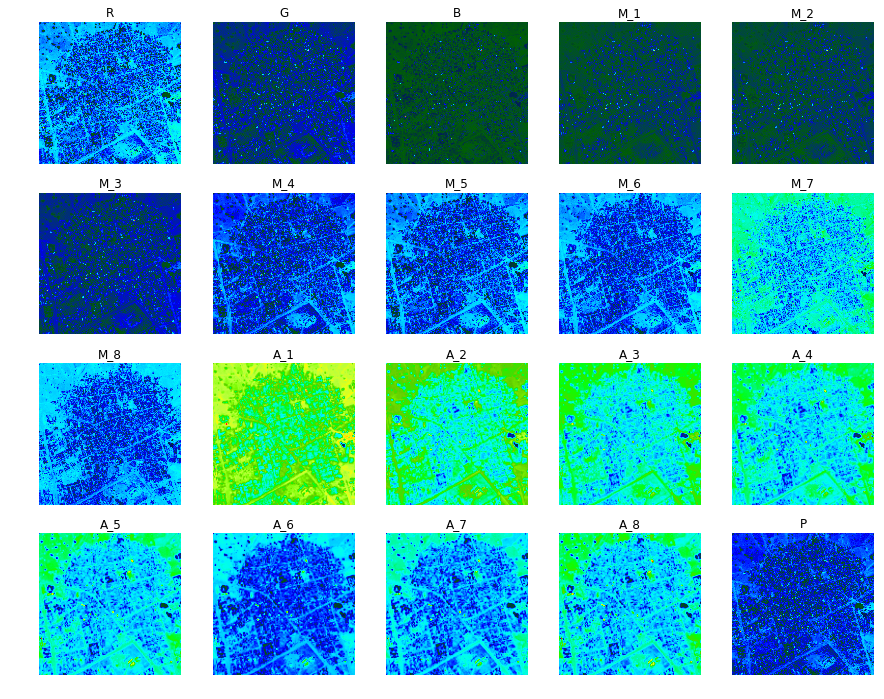

In [8]:
Plot_Image_Allband(Image_ID[17])

## 2.2 Get training label

In [23]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=grid_size, wkt_list_pandas=train_wkt):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask
def Plot_Mask_Allband(image_id):  
    img = Get_Image_Allband(image_id)
    plt.figure(figsize=[15,6])
    for i in range(1,11):
        plt.subplot(2,5,i)
        mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),image_id, i)
        plt.imshow(mask[:, :],cmap=plt.get_cmap('gist_ncar'))
        plt.title(ClassName[i-1])
        plt.axis('off')
    plt.show() 

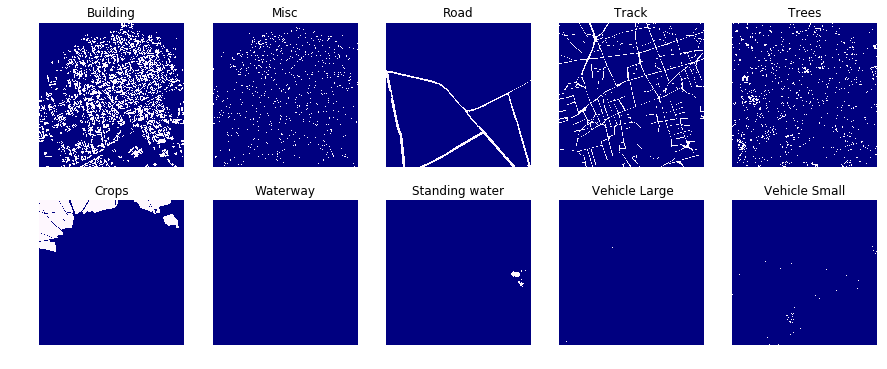

In [11]:
Plot_Mask_Allband(Image_ID[17])

## 2.3 Get patches

The original image size is too large for being directly used for training in the CNN. Here I get patches from the original image with the selected input size for the CNN. In this project, I used 224 as the input size of CNN. The input size has effect on the performance of CNN, I choose 224 here after experiments of different input sizes.

In [29]:
# Get split patch from image for select class_type
# pos = 0 get all patches
# pos = 1 get non-empty patches only
def get_patch(img_id,pos = 1):
    N_patch = N_split**2
    x_all = []
    img = Get_Image_Allband(img_id)
    mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),img_id, Class_Type)
    for i in range(N_split):
        for j in range(N_split):   
            y = mask[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0) :
                x = img[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1),:]
                x_all.append(np.concatenate((x,y[:,:,None]),axis = 2))
    x_all = np.asarray(x_all)
    return x_all
def get_all_patches(pos = 1):
    x = []
    count = 0
    for img_id in Image_ID:
        x_all = get_patch(img_id,pos = pos)
#         print ([img_id,len(x_all)])
        if len(x_all) > 0:
            count = count + 1
            if count == 1: 
                x = x_all
            else:
                x = np.concatenate((x,x_all),axis = 0)
    if pos == 1:
        np.save(Dir + '/output/data_pos_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    else:
        np.save(Dir + '/output/data_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    print (x.shape)
#     return x

Simply generate random patches from all images for all classes will lead to problem in class imbalances since there would be many empty patches. Here, I removed the patches with empty mask.

In [37]:
# begin_time = time.time()           
# get_all_patches()
# end_time = time.time()
# print('time lapsing {0} s \n'.format(end_time - begin_time))

# 3. Model Training

## 3.1 Unet_baseline

In [57]:
def get_normalized_patches():
    data = get_all_patches()
#     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = data[:,:,:,:20]
    msk = data[:,:,:,20]
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean)/std
    print (mean,std)
    print (np.mean(img),np.std(img))
    return img,msk

In [59]:
img,msk = get_normalized_patches()

0.229798 0.097015
6.15149e-06 1.0


In [38]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.229798,std =0.097015):
    img = (img - mean)/std
    return img

In [39]:
def get_unet_5():
#     Patch_size = 224
    inputs = Input((Patch_size, Patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [102]:
x_trn, x_val, y_trn, y_val = train_test_split(img, msk,test_size=0.2, random_state=42)
y_trn = y_trn[:,:,:,None]
y_val = y_val[:,:,:,None]
model = get_unet_5()
model_checkpoint = ModelCheckpoint('unet5_c1_{epoch:02d}.hdf5')
model.fit(x_trn, y_trn, batch_size=16, epochs=100, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))

Train on 955 samples, validate on 239 samples
Epoch 1/100
955/955 [==============================] - 251s - loss: 0.3468 - acc: 0.8735 - val_loss: 0.2592 - val_acc: 0.9050
Epoch 2/100
955/955 [==============================] - 252s - loss: 0.2543 - acc: 0.9044 - val_loss: 0.2303 - val_acc: 0.9132
Epoch 3/100
955/955 [==============================] - 252s - loss: 0.2399 - acc: 0.9086 - val_loss: 0.2362 - val_acc: 0.9110
Epoch 4/100
955/955 [==============================] - 252s - loss: 0.2104 - acc: 0.9184 - val_loss: 0.2183 - val_acc: 0.9184
Epoch 5/100
955/955 [==============================] - 252s - loss: 0.1975 - acc: 0.9223 - val_loss: 0.1927 - val_acc: 0.9236
Epoch 6/100
955/955 [==============================] - 252s - loss: 0.1806 - acc: 0.9278 - val_loss: 0.1834 - val_acc: 0.9282
Epoch 7/100
955/955 [==============================] - 252s - loss: 0.1816 - acc: 0.9281 - val_loss: 0.1761 - val_acc: 0.9303
Epoch 8/100
955/955 [==============================] - 252s - loss: 0.20

In [27]:
model = get_unet_5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      5792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
__________

## 3.2 Model Evaluation

In [39]:
def calc_jacc(model,img,msk):
    msk = msk[:,:,:,None]
    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0]*msk.shape[1],msk.shape[2])
    prd = prd.reshape(prd.shape[0]*prd.shape[1],prd.shape[2])
    # loop over threshold to find the one with highest score
    score = 0
    scores = []
    for j in range(10):
        th = j / 10.0
        pred_binary_mask = prd > th
        jk = jaccard_similarity_score(msk, pred_binary_mask)
        scores.append(jk)
        if jk > score:
            score = jk
            best_th = th
    print('Jaccord Index :{0:.8f}'.format(score))
    print('Best Threshold :{0:.1f}'.format(best_th))
    return score, best_th

def calc_jacc_th(model,img,msk,th):
    msk = msk[:,:,:,None]
    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0]*msk.shape[1],msk.shape[2])
    prd = prd.reshape(prd.shape[0]*prd.shape[1],prd.shape[2])
    pred_binary_mask = prd > th
    score = jaccard_similarity_score(msk, pred_binary_mask)
    print('Jaccord Index with threshold {0:.1f} :{1:.8f}'.format(th,score))
    return score

In [40]:
def predict_id(img_id, model, th):
    img = Get_Image_Allband(img_id)
    img = post_normalize_image(img)
    
    prd = np.zeros((Patch_size*N_split, Patch_size*N_split,1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):   
            x = img[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1),:]
            tmp = model.predict(x[None,:,:,:],batch_size = 4)
            prd[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1)] = tmp
    prd = prd > th       
    return prd

def check_predict(model,th,img_id=Image_ID[17],Class_Type = 1):  
    msk_prd = predict_id(img_id, model, th)
    msk_prd = msk_prd[:,:,0]
    img = Get_Image_Allband(img_id)
    msk = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),img_id, Class_Type)
    
    plt.figure(figsize=[14,8])
    plt.subplot(1,2,1)
    plt.title('Training Mask')
    plt.imshow(msk,cmap=plt.get_cmap('gist_ncar'))
    plt.subplot(1,2,2)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd,cmap=plt.get_cmap('gist_ncar'))
    plt.axis('off')
    plt.show()

In [15]:
# model = get_unet_5()
# scores = []
# for i in range(50):
#     filename = '/output/unet5_c1_{0:02d}.hdf5'.format(i)
#     print(filename)
#     model.load_weights(filename)
#     th_trn = 0.5
#     score_trn = calc_jacc_th(model,x_trn,y_trn,th_trn)
#     score_val = calc_jacc_th(model,x_val,y_val,th_trn)
#     scores.append([i+1, th_trn, score_trn,score_val])
#     scores_unet5 = np.asarray(scores)
#     np.save('unet_5_score_th05',scores_unet5)

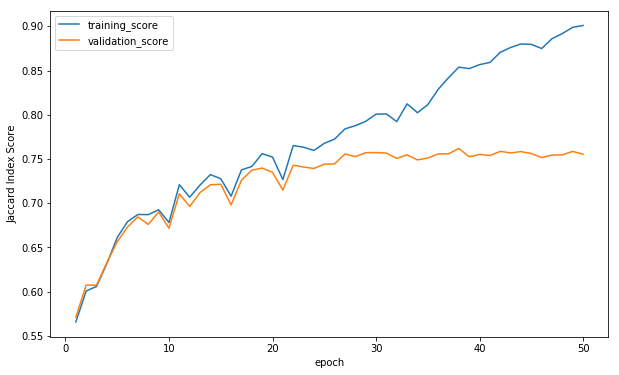

In [14]:
scores_unet5 = np.load('/trained/unet_5_score_th05.npy')
plt.figure(figsize=[10,6])
plt.plot(scores_unet5[:,0],scores_unet5[:,2])
plt.plot(scores_unet5[:,0],scores_unet5[:,3])
plt.xlabel('epoch')
plt.ylabel('Jaccard Index Score')
plt.legend(['training_score','validation_score'])
plt.title('Training score with Unet of depth 5 for Class 1')
plt.show()

In [11]:
scores_unet5[np.argmax(scores_unet5[:,3]),:]

array([ 38.        ,   0.5       ,   0.853933  ,   0.76193687])

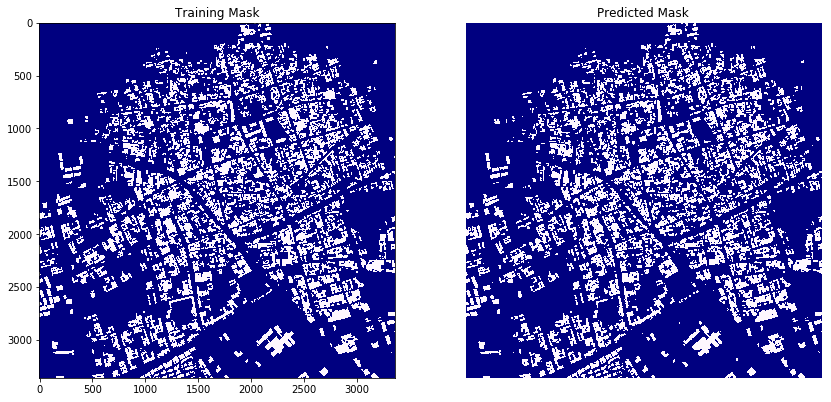

In [73]:
model = get_unet_5()  
model.load_weights('/trained/unet5_c1_37.hdf5')
check_predict(model,0.5)

## 3.3 Model Tuning

### 3.3.1 Depth of Unet

In [41]:
def get_unet_6():
#     Patch_size = 224
    inputs = Input((Patch_size, Patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
#     drop5 = Dropout(0.5)(conv5)

    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv5, up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv4, up8], axis = 3)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv3,up9], axis = 3)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    up10 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv2,up10], axis = 3)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    
    up11 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
    merge11 = concatenate([conv1,up11], axis = 3)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
        
#     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation = 'sigmoid')(conv11)

    model = Model(inputs = inputs, outputs = conv12)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
#     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])     
    
    return model

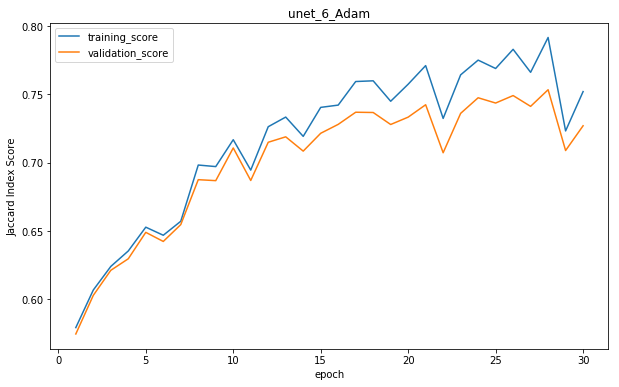

In [52]:
scores_unet6 = np.load('/trained/unet_6_score_Adam.npy')
scores_unet6[np.argmax(scores_unet6[:,3]),:]
plt.figure(figsize=[10,6])
plt.plot(scores_unet6[:30,0],scores_unet6[:30,2])
plt.plot(scores_unet6[:30,0],scores_unet6[:30,3])
plt.xlabel('epoch')
plt.ylabel('Jaccard Index Score')
plt.title('unet_6_Adam')
plt.legend(['training_score','validation_score'])
plt.show()
scores_unet6_adam = scores_unet6

### 3.3.2 Adding Dropout Layers

In [44]:
def get_unet_6_dropout(dropout = 0.5):
#     Patch_size = 224
    inputs = Input((Patch_size, Patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(dropout)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(drop5)

    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    drop6 = Dropout(dropout)(conv6)

    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = concatenate([conv5, up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop7 = Dropout(dropout)(conv7)

    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv4, up8], axis = 3)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv3,up9], axis = 3)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    up10 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv2,up10], axis = 3)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    
    up11 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
    merge11 = concatenate([conv1,up11], axis = 3)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
        
#     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation = 'sigmoid')(conv11)

    model = Model(inputs = inputs, outputs = conv12)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
#     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])   

    return model

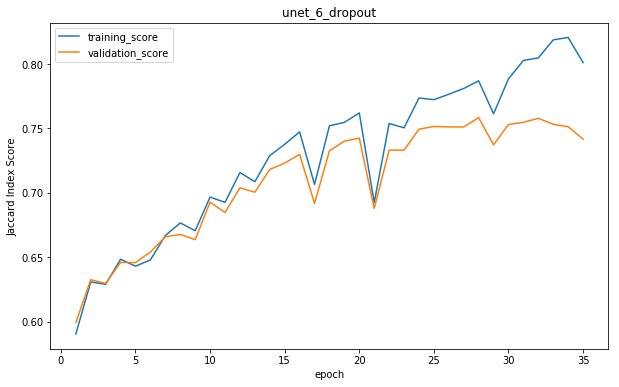

In [53]:
scores_unet6 = np.load('/trained/unet_6_score_dropout.npy')
scores_unet6[np.argmax(scores_unet6[:,3]),:]
plt.figure(figsize=[10,6])
plt.plot(scores_unet6[:35,0],scores_unet6[:35,2])
plt.plot(scores_unet6[:35,0],scores_unet6[:35,3])
plt.xlabel('epoch')
plt.ylabel('Jaccard Index Score')
plt.title('unet_6_dropout')
plt.legend(['training_score','validation_score'])
plt.show()
scores_unet6_dropout = scores_unet6

Although no big effects are shown here. Changing the depth of Unet and adding dropout layers are strategies that can be used for training the models for other class types to improve the accuracy.

### 3.3.3  Performance of different optimization methods

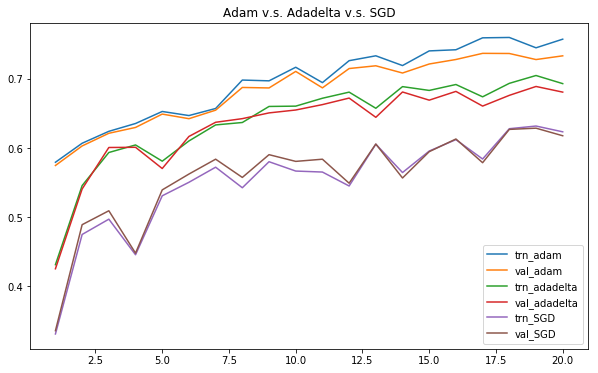

In [51]:
scores_unet6_SGD = np.load('/trained/unet_6_score_SGD.npy')
scores_unet6_adadelta = np.load('/trained/unet_6_score_Adadelta.npy')
plt.figure(figsize=[10,6])
xlim = 20
plt.plot(scores_unet6_adam[:xlim,0],scores_unet6_adam[:xlim,2])
plt.plot(scores_unet6_adam[:xlim,0],scores_unet6_adam[:xlim,3])
plt.plot(scores_unet6_adadelta[:xlim,0],scores_unet6_adadelta[:xlim,2])
plt.plot(scores_unet6_adadelta[:xlim,0],scores_unet6_adadelta[:xlim,3])
plt.plot(scores_unet6_SGD[:xlim,0],scores_unet6_SGD[:xlim,2])
plt.plot(scores_unet6_SGD[:xlim,0],scores_unet6_SGD[:xlim,3])
plt.title('Adam v.s. Adadelta v.s. SGD')
plt.legend(['trn_adam','val_adam','trn_adadelta','val_adadelta','trn_SGD','val_SGD'])
plt.show()

As shown in the figure above, the optimization method adam converges much faster than other optmization methods.